In [1]:
import pandas as pd
import numpy as np
from numpy.random import randint
from numpy.random import rand
import time
import matplotlib.pyplot as plt
tdata = pd.read_csv(r"C:\Users\Nguyen Ngoc\Desktop\sinusoidal_raster_ngoc\10_Hz_124432_trace_Z_.txt" , sep= '\t', decimal='.', header = None)
rdata = pd.read_csv(r"C:\Users\Nguyen Ngoc\Desktop\sinusoidal_raster_ngoc\10_Hz_124432_retrace_Z_.txt", sep= '\t',  decimal='.', header = None,  dtype=np.float64 )
tdata_array = np.array(tdata)
rdata_array = np.array(rdata)

In [2]:
def distance_map(tdata, rdata):
  min_index_list = []
  for i in range(int(len(tdata.T))):
    #subtract along the first axis, first column of tdata subtracted to all column in rdata in a broadcasted manner
    substract = np.subtract(tdata[:,i].reshape(len(tdata),1), rdata)
    # square the subtract value
    power = np.power(substract, 2)
    # sum along the 1st axis
    sum = np.sum(power, axis = 0)
    # root square as in accord with Euclidean norm
    sqrt = np.sqrt(sum)
    # find the correlated index in the backward image
    min_index = np.argmin(sqrt)
    min_index_list.append(min_index)
  return min_index_list

In [3]:
trace_map = distance_map(tdata_array, rdata_array)
retrace_map = distance_map(rdata_array, tdata_array)

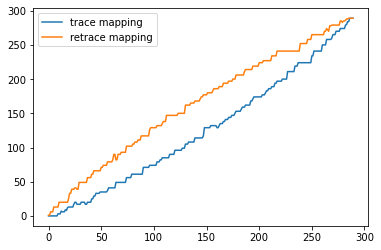

In [4]:
import matplotlib.pyplot as plt
plt.plot(list(range(len(tdata_array.T))),trace_map, label = "trace mapping" )
plt.plot(list(range(len(rdata_array.T))), retrace_map, label = "retrace mapping" )
plt.legend(loc = "upper left")
plt.show()

In [5]:
### GA

## Helper function

# initialize the command point list

def command_point(max_pixel):
  ###initialize the command point vector
  init_command = np.arange(0, 290, 1)
  norm_command = init_command/(max_pixel-1)
  return norm_command
#print(command_point(max_pixel))

# population initialization

def population(pop_size, sol_size):
  ##
  pop = [np.random.rand(sol_size,1) + 1 for _ in range(pop_size)]
  return pop
# fit function
def motion_fn(command_points, sol):
  func_order = 10
  min_val =1
  #alpha = np.random.rand(func_order,1) + min_val
  #print("alpha", alpha)
  power = np.power(command_points, sol).real
  #print(power.shape)
  sum = np.sum(power, axis = 0)
  f_anfa = sum/func_order
  return f_anfa

# optimization

def fitness_fn(sol, max_pixel):
  ##optimization function to check min error
  target = np.array(retrace_map)/(max_pixel-1)
  f = motion_fn(command_point(max_pixel), sol)
  inverse_f = [0 if c == 0 else complex(1/c)  for c in f ] 
  one_sub_inverse_f = 1 - np.array(inverse_f)
  #print("inverse_f \n", inverse_f)
  f_anfa_2 = motion_fn(one_sub_inverse_f, sol)
  #print("f_anfa_2 \n",f_anfa_2)
  subtract = np.subtract(target, (1 - f_anfa_2))
  #print("subtract \n", subtract)
  power = np.power(subtract, 2)
  sum = np.sum(power)
  scores = np.sqrt(sum)
  return scores

# tournament selection

def selection(pop, scores, k=3):
	# first random selection
	selection_ix = randint(len(pop))
	for ix in randint(0, len(pop), k-1):
		# check if better (e.g. perform a tournament)
		if scores[ix] < scores[selection_ix]:
			selection_ix = ix
	return pop[selection_ix]

# crossover 

def crossover(p1, p2, r_cross):
  # children are copies of parents by defatl
  c1, c2 = p1.copy(), p2.copy()
  #check for recombination
  if rand() < r_cross:
    # select crossover point that is not on the end of the string
    pt = randint(1, len(p1) -2)
    # perform crossover
    c1 = np.concatenate((p1[:pt], p2[pt:]), axis = 0)
    c2 = np.concatenate((p1[pt:], p2[:pt]), axis = 0)
  return [c1, c2]

# mutation operator
def mutation(bitstring, r_mut): 
  bitstring = bitstring
  for i in range(len(bitstring)):
    # check for a mutation
    if rand() < r_mut:
      # flip the bit
      bitstring[i] = np.random.rand(1,1) + 1
  return bitstring

# genetic_algorithm merged into optimisation

def genetic_algorithm(sol_size, n_iter, pop_size, r_cross, r_mut, max_pixel):
  time_start = time.time()
  # initial population of random bitstring
  pop = population(pop_size, sol_size)
  best, best_eval = 0, fitness_fn(pop[0], max_pixel)
  for gen in range(n_iter):
    scores = [fitness_fn(sol, max_pixel) for sol in pop]
    for i in range(pop_size):
      if scores[i] < best_eval:
        best, best_eval = pop[i], scores[i]
        print(">%d, new best f(%s) = %.3f" % (gen,  pop[i], scores[i]))
    selected = [selection(pop, scores) for _ in range(pop_size)]
    # create the next generation
    children = []
    for i in range(0, pop_size, 2):
      # get selected parents in pairs
      p1, p2 = selected[i], selected[i+1]
      # crossover and mutation
      for c in crossover(p1, p2, r_cross):
        #mutation
        mutation(c, r_mut)
        #store for the next generation
        children.append(c)
    #replace population
    pop = children
  print("Total runing time is %.3f after %d of interations, fitness score is %.3f :" %((time.time() - time_start), gen, best_eval) )
  return [best, best_eval]


In [6]:
sol_size = 10
n_iter = 5000
pop_size = 200
r_cross = 0.5
r_mut = 0.3/float(sol_size)
max_pixel = 290
best, score = genetic_algorithm(sol_size, n_iter, pop_size, r_cross, r_mut, max_pixel)

>0, new best f([[1.60695817]
 [1.7087889 ]
 [1.27734943]
 [1.85875681]
 [1.34016892]
 [1.42757873]
 [1.12049056]
 [1.51285601]
 [1.1016344 ]
 [1.63092923]]) = 130973.361
>0, new best f([[1.01059732]
 [1.81445563]
 [1.61623648]
 [1.79888277]
 [1.01971371]
 [1.8094566 ]
 [1.81642556]
 [1.48459744]
 [1.0898895 ]
 [1.49943112]]) = 112211.853
>0, new best f([[1.11491019]
 [1.47760651]
 [1.68009558]
 [1.60436655]
 [1.09985099]
 [1.38853827]
 [1.36538287]
 [1.11695915]
 [1.68582613]
 [1.68035607]]) = 35556.864
>0, new best f([[1.08010446]
 [1.13194728]
 [1.19643698]
 [1.53553311]
 [1.30202191]
 [1.57523403]
 [1.69578381]
 [1.33122128]
 [1.28042302]
 [1.14761947]]) = 8437.039
>0, new best f([[1.13807567]
 [1.33309223]
 [1.24716334]
 [1.4936157 ]
 [1.03734247]
 [1.12758692]
 [1.3169994 ]
 [1.35277484]
 [1.32818709]
 [1.08755947]]) = 3011.272
>0, new best f([[1.33587389]
 [1.07226007]
 [1.27883193]
 [1.07208713]
 [1.00353651]
 [1.1805646 ]
 [1.07779264]
 [1.65629943]
 [1.28972487]
 [1.56774737]]

In [7]:
import pandas as pd
best_df = pd.DataFrame(best)
best_df.to_pickle(r"C:\Users\Nguyen Ngoc\Desktop\sinusoidal_raster_ngoc\optimized parameter\10_Hz_124432_best_df.pickle.gz")

In [8]:
best_df = pd.read_pickle(r"C:\Users\Nguyen Ngoc\Desktop\sinusoidal_raster_ngoc\optimized parameter\10_Hz_124432_best_df.pickle.gz")
best_arr = np.array(best_df)
print(best_arr)
print(score)

[[1.49772709]
 [1.49772709]
 [1.51148281]
 [1.48939803]
 [1.49775409]
 [1.51148281]
 [1.49772709]
 [1.49772709]
 [1.49772709]
 [1.49772709]]
17.754790485852972


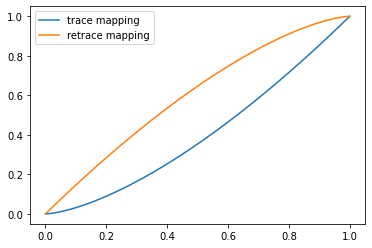

In [9]:
# plot the predicted curve
x_trace = command_point(290)
x_retrace = np.subtract(1,x_trace)
y_trace = motion_fn(x_trace, best_arr)
y_retrace = np.subtract(1, y_trace)
plt.plot(x_trace, y_trace, label = "trace mapping" )
#plt.plot(np.array(list(range(len(tdata_array.T))))/289,np.array(trace_map)/289, label = "real_trace mapping" )
#plt.plot(np.array(list(range(len(rdata_array.T))))/289, np.array(retrace_map)/289, label = "real_retrace mapping" )
plt.plot(x_retrace, y_retrace, label = "retrace mapping" )
plt.legend(loc = "upper left")
plt.show()

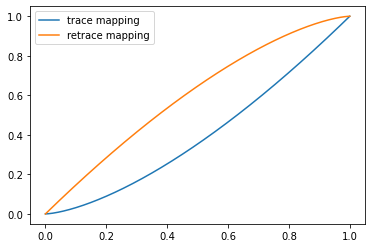

In [10]:
## Verify the above curve by another way of calculation for retrace map~
x_trace = command_point(290)
x_retrace = np.subtract(1,x_trace)
y_trace = motion_fn(x_trace, best_arr)
y_retrace = np.subtract(1, motion_fn(x_retrace, best_arr))
plt.plot(x_trace, y_trace, label = "trace mapping" )
#plt.plot(list(range(len(tdata_array.T))),trace_map, label = "real_trace mapping" )
#plt.plot(list(range(len(rdata_array.T))), retrace_map, label = "real_retrace mapping" )
plt.plot(x_trace, y_retrace, label = "retrace mapping" )
plt.legend(loc = "upper left")
plt.show()

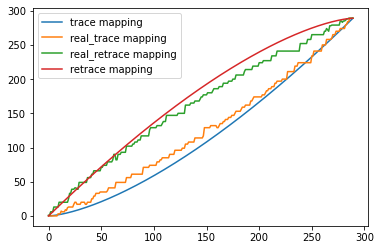

In [11]:
# compare predicted curve with true curve
x_trace = command_point(290)
x_retrace = np.subtract(1,x_trace)
y_trace = motion_fn(x_trace, best_arr)
y_retrace = np.subtract(1, motion_fn(x_retrace, best_arr))
plt.plot(x_trace*289, y_trace*289, label = "trace mapping" )
plt.plot(list(range(len(tdata_array.T))),trace_map, label = "true_trace mapping" )
plt.plot(list(range(len(rdata_array.T))), retrace_map, label = "true_retrace mapping" )
plt.plot(x_trace*289, y_retrace*289, label = "retrace mapping" )
plt.legend(loc = "upper left")
plt.show()

In [12]:
## FOr the second test changing the parameter by increase the n_iter, or reduce probability of crossover, mutation
# need to declare the other filename to not overwrite the last result
sol_size = 10
n_iter = 10000
pop_size = 250
r_cross = 0.7
r_mut = 0.3/float(sol_size)
max_pixel = 290
best, score = genetic_algorithm(sol_size, n_iter, pop_size, r_cross, r_mut, max_pixel)

>0, new best f([[1.87782242]
 [1.380478  ]
 [1.02075297]
 [1.89045337]
 [1.96460094]
 [1.21798459]
 [1.1909124 ]
 [1.43024542]
 [1.75515144]
 [1.70100751]]) = 472170.220
>0, new best f([[1.38345206]
 [1.63725359]
 [1.41627695]
 [1.45091942]
 [1.3199838 ]
 [1.68594769]
 [1.86890646]
 [1.25359326]
 [1.52374226]
 [1.5094139 ]]) = 438413.280
>0, new best f([[1.62742007]
 [1.81020181]
 [1.50348375]
 [1.08969493]
 [1.74069151]
 [1.1497984 ]
 [1.9602968 ]
 [1.44378599]
 [1.10730274]
 [1.53514843]]) = 276591.942
>0, new best f([[1.2555715 ]
 [1.87889261]
 [1.63594939]
 [1.06791693]
 [1.85804536]
 [1.13087798]
 [1.04825914]
 [1.27294964]
 [1.67045058]
 [1.25056684]]) = 96475.298
>0, new best f([[1.28074662]
 [1.13219103]
 [1.83074571]
 [1.17933636]
 [1.58121609]
 [1.79917989]
 [1.07501254]
 [1.09443835]
 [1.34672898]
 [1.33062991]]) = 56390.211
>0, new best f([[1.35258891]
 [1.48347876]
 [1.2429719 ]
 [1.24260145]
 [1.56932973]
 [1.00496357]
 [1.60742011]
 [1.33805964]
 [1.38543786]
 [1.6773649

In [13]:
import pandas as pd
best_df = pd.DataFrame(best)
best_df.to_pickle(r"C:\Users\Nguyen Ngoc\Desktop\sinusoidal_raster_ngoc\optimized parameter\10_Hz_124432_best_df1.pickle.gz")

In [14]:
best_df = pd.read_pickle(r"C:\Users\Nguyen Ngoc\Desktop\sinusoidal_raster_ngoc\optimized parameter\10_Hz_124432_best_df1.pickle.gz")
best_arr = np.array(best_df)
print(best_arr)
print(score)

[[1.49027872]
 [1.49023909]
 [1.49023909]
 [1.49023909]
 [1.50784609]
 [1.50778501]
 [1.49023909]
 [1.50778501]
 [1.50778501]
 [1.51061364]]
28.990908589909232


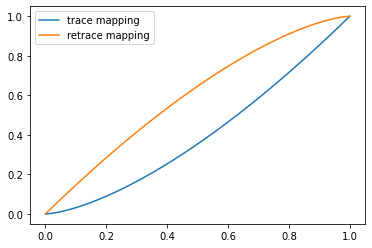

In [15]:
# plot the predicted curve
x_trace = command_point(290)
x_retrace = np.subtract(1,x_trace)
y_trace = motion_fn(x_trace, best_arr)
y_retrace = np.subtract(1, y_trace)
plt.plot(x_trace, y_trace, label = "trace mapping" )
#plt.plot(np.array(list(range(len(tdata_array.T))))/289,np.array(trace_map)/289, label = "real_trace mapping" )
#plt.plot(np.array(list(range(len(rdata_array.T))))/289, np.array(retrace_map)/289, label = "real_retrace mapping" )
plt.plot(x_retrace, y_retrace, label = "retrace mapping" )
plt.legend(loc = "upper left")
plt.show()

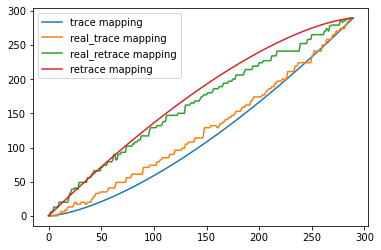

In [16]:
import matplotlib.pyplot as plt
x_trace = command_point(290)
x_retrace = np.subtract(1,x_trace)
y_trace = motion_fn(x_trace, best_arr)
y_retrace = np.subtract(1, motion_fn(x_retrace, best_arr))
plt.plot(x_trace*289, y_trace*289, label = "trace mapping" )
plt.plot(list(range(len(tdata_array.T))),trace_map, label = "real_trace mapping" )
plt.plot(list(range(len(rdata_array.T))), retrace_map, label = "real_retrace mapping" )
plt.plot(x_trace*289, y_retrace*289, label = "retrace mapping" )
plt.legend(loc = "upper left")
plt.show()

In [29]:
def retrace_motion_fn(x_retrace, best_sol):
    f = motion_fn(x_retrace, best_sol)
    inverse_f = [0 if c == 0 else complex(1/c)  for c in f ]
    retrace_f = motion_fn(inverse_f, best_sol)
    return retrace_f
    